In [1]:
!rm -rf nd320-c4-wearable-data-project-starter
!git clone https://github.com/udacity/nd320-c4-wearable-data-project-starter.git

Cloning into 'nd320-c4-wearable-data-project-starter'...
remote: Enumerating objects: 1777, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 1777 (delta 2), reused 7 (delta 0), pack-reused 1767 (from 1)
Receiving objects: 100% (1777/1777), 344.92 MiB | 29.11 MiB/s, done.
Resolving deltas: 100% (940/940), done.
Updating files: 100% (1575/1575), done.


## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project.
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [42]:
import glob
import numpy as np
import scipy as sp
import scipy.io
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt


def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the
            reference data for data_fls[5], etc...
    """
    data_dir = "/content/nd320-c4-wearable-data-project-starter/part_1/datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
        Note: data[2] = PPG, data[3] = accx, data[4] = accy, data[5] = accz
        Here, data[2:] extracts these four signals accordingly.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]


def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability.

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

def bandpass_filter(signal, fs, lowcut=0.67, highcut=4.0, order=4):
    """
    Applies a Butterworth bandpass filter.

    Args:
        signal (np.array): signal to filter
        fs (float): sampling frequency (Hz)
        lowcut (float): low cutoff frequency (Hz)
        highcut (float): high cutoff frequency (Hz)
        order (int): filter order

    Returns:
        np.array: filtered signal
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def RunPulseRateAlgorithm(data_fl, ref_fl):
    """
    Calculate heart rate error and confidence on a data file.
    Enhanced version with accelerometer consideration for confidence.

    Args:
        data_fl (str): path to the data file (.mat)
        ref_fl (str): path to the reference file (.mat)

    Returns:
        Tuple (errors, confidence) numpy arrays
    """
    # Load PPG and accelerometer data
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    fs = 125  # sampling frequency in Hz

    # Basic check: ensure signal length is sufficient for windowing
    if len(ppg) < 8 * fs:
        raise ValueError("Signal length is too short for 8-second window processing.")

    # Bandpass filter the PPG signal (40-240 BPM)
    ppg_filtered = bandpass_filter(ppg, fs)

    # Compute accelerometer norm and apply bandpass filter
    acc_norm = np.sqrt(accx**2 + accy**2 + accz**2)
    acc_filtered = bandpass_filter(acc_norm, fs)

    window_size = 8 * fs  # 8-second window
    step_size = 2 * fs    # 2-second step
    n_windows = (len(ppg_filtered) - window_size) // step_size + 1

    pulse_rates = []
    confidences = []

    # Load reference heart rate data
    ref_data = sp.io.loadmat(ref_fl)['BPM0'].flatten()
    previous_bpm = None  # track previous heart rate for physiological constraint

    for i in range(n_windows):
        start = i * step_size
        end = start + window_size

        # Extract current PPG window
        window_ppg = ppg_filtered[start:end]

        # Compute FFT of PPG window
        freqs = np.fft.rfftfreq(len(window_ppg), 1/fs)
        fft_mag = np.abs(np.fft.rfft(window_ppg))

        # Restrict to physiological frequency band (0.67-4 Hz ~ 40-240 BPM)
        valid_idx = np.where((freqs >= 0.67) & (freqs <= 4.0))
        freqs_valid = freqs[valid_idx]
        mag_valid = fft_mag[valid_idx]

        # Detect dominant frequency in PPG signal
        peak_idx = np.argmax(mag_valid)
        peak_freq = freqs_valid[peak_idx]

        # Extract accelerometer window and compute FFT
        window_acc = acc_filtered[start:end]
        acc_fft_mag = np.abs(np.fft.rfft(window_acc))
        acc_freqs = np.fft.rfftfreq(len(window_acc), 1/fs)

        # Restrict accelerometer FFT to physiological band
        valid_acc_idx = np.where((acc_freqs >= 0.67) & (acc_freqs <= 4.0))
        acc_freqs_valid = acc_freqs[valid_acc_idx]
        acc_mag_valid = acc_fft_mag[valid_acc_idx]

        # Detect dominant frequency in accelerometer signal
        acc_peak_idx = np.argmax(acc_mag_valid)
        acc_peak_freq = acc_freqs_valid[acc_peak_idx]

        # Convert frequency to BPM
        current_bpm = peak_freq * 60

        # Physiological constraint: max 3 BPM change between consecutive windows
        if previous_bpm is not None and abs(current_bpm - previous_bpm) > 3:
            current_bpm = previous_bpm + 3 * np.sign(current_bpm - previous_bpm)

        pulse_rates.append(current_bpm)
        previous_bpm = current_bpm

        # Calculate confidence: energy around peak ±0.1 Hz
        band_width = 0.1
        band_idx = np.where((freqs_valid >= peak_freq - band_width) & (freqs_valid <= peak_freq + band_width))
        energy_band = np.sum(mag_valid[band_idx])
        energy_total = np.sum(mag_valid)
        confidence = energy_band / energy_total if energy_total > 0 else 0

        # Confidence represents the proportion of signal energy concentrated around the detected peak frequency.
        # A higher confidence means the peak is more dominant and the estimate is more reliable.

        # Moderate confidence reduction if PPG and accelerometer frequencies are close (likely motion artifact)
        if abs(peak_freq - acc_peak_freq) < 0.1:
            if confidence < 0.6:  # empirical threshold to avoid penalizing good estimates
                confidence *= 0.7  # gentle reduction

        confidences.append(confidence)

    # Convert results to numpy arrays
    pulse_rates = np.array(pulse_rates)
    confidences = np.array(confidences)

    # Trim reference to match estimation length
    ref_trim = ref_data[:len(pulse_rates)]

    # Calculate absolute errors
    errors = np.abs(pulse_rates - ref_trim)

    return errors, confidences


In [3]:
def bandpass_filter(signal, fs, lowcut=0.67, highcut=4.0, order=4):
    """
    Applique un filtre passe-bande Butterworth.

    Args:
        signal (np.array): signal à filtrer
        fs (float): fréquence d'échantillonnage (Hz)
        lowcut (float): fréquence basse (Hz)
        highcut (float): fréquence haute (Hz)
        order (int): ordre du filtre

    Returns:
        np.array: signal filtré
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

In [23]:
def RunPulseRateAlgorithm(data_fl, ref_fl):
    """
    Calculate heart rate error and confidence on a data file.
    Enhanced version with accelerometer consideration for confidence.

    Args:
        data_fl (str): path to the data file (.mat)
        ref_fl (str): path to the reference file (.mat)

    Returns:
        Tuple (errors, confidence) numpy arrays
    """
    # Load PPG and accelerometer data
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    fs = 125  # sampling frequency in Hz

    # Bandpass filter the PPG signal (40-240 BPM)
    ppg_filtered = bandpass_filter(ppg, fs)

    # Compute accelerometer norm and apply bandpass filter
    acc_norm = np.sqrt(accx**2 + accy**2 + accz**2)
    acc_filtered = bandpass_filter(acc_norm, fs)

    window_size = 8 * fs  # 8-second window
    step_size = 2 * fs    # 2-second step
    n_windows = (len(ppg_filtered) - window_size) // step_size + 1

    pulse_rates = []
    confidences = []

    # Load reference heart rate data
    ref_data = sp.io.loadmat(ref_fl)['BPM0'].flatten()
    previous_bpm = None  # track previous heart rate for physiological constraint

    for i in range(n_windows):
        start = i * step_size
        end = start + window_size

        # Extract current PPG window
        window_ppg = ppg_filtered[start:end]

        # Compute FFT of PPG window
        freqs = np.fft.rfftfreq(len(window_ppg), 1/fs)
        fft_mag = np.abs(np.fft.rfft(window_ppg))

        # Restrict to physiological frequency band (0.67-4 Hz ~ 40-240 BPM)
        valid_idx = np.where((freqs >= 0.67) & (freqs <= 4.0))
        freqs_valid = freqs[valid_idx]
        mag_valid = fft_mag[valid_idx]

        # Detect dominant frequency
        peak_idx = np.argmax(mag_valid)
        peak_freq = freqs_valid[peak_idx]

        # Extract accelerometer window and compute FFT
        window_acc = acc_filtered[start:end]
        acc_fft_mag = np.abs(np.fft.rfft(window_acc))
        acc_freqs = np.fft.rfftfreq(len(window_acc), 1/fs)

        # Restrict accelerometer FFT to physiological band
        valid_acc_idx = np.where((acc_freqs >= 0.67) & (acc_freqs <= 4.0))
        acc_freqs_valid = acc_freqs[valid_acc_idx]
        acc_mag_valid = acc_fft_mag[valid_acc_idx]

        # Dominant accelerometer frequency
        acc_peak_idx = np.argmax(acc_mag_valid)
        acc_peak_freq = acc_freqs_valid[acc_peak_idx]

        # Convert frequency to BPM
        current_bpm = peak_freq * 60

        # Physiological constraint: max 3 BPM change between consecutive windows
        if previous_bpm is not None and abs(current_bpm - previous_bpm) > 3:
            current_bpm = previous_bpm + 3 * np.sign(current_bpm - previous_bpm)

        pulse_rates.append(current_bpm)
        previous_bpm = current_bpm

        # Calculate confidence: energy around peak ±0.1 Hz
        band_width = 0.1
        band_idx = np.where((freqs_valid >= peak_freq - band_width) & (freqs_valid <= peak_freq + band_width))
        energy_band = np.sum(mag_valid[band_idx])
        energy_total = np.sum(mag_valid)
        confidence = energy_band / energy_total if energy_total > 0 else 0

        # Moderate confidence reduction if PPG and accelerometer frequencies are close
        if abs(peak_freq - acc_peak_freq) < 0.1:
            if confidence < 0.6:  # empirical threshold to avoid penalizing good estimates
                confidence *= 0.7  # gentle reduction

        confidences.append(confidence)

    # Convert results to numpy arrays
    pulse_rates = np.array(pulse_rates)
    confidences = np.array(confidences)

    # Trim reference to match estimation length
    ref_trim = ref_data[:len(pulse_rates)]

    # Calculate absolute errors
    errors = np.abs(pulse_rates - ref_trim)

    return errors, confidences



In [49]:
import matplotlib.pyplot as plt
import numpy as np

def plot_signals(ppg, accx, accy, accz, fs, duration_sec=30):
    """
    Plots the PPG and accelerometer signals over time.

    Args:
        ppg (np.array): PPG signal.
        accx (np.array): Accelerometer X signal.
        accy (np.array): Accelerometer Y signal.
        accz (np.array): Accelerometer Z signal.
        fs (int): Sampling frequency (Hz).
        duration_sec (int): Duration to plot in seconds.
    """
    t = np.arange(len(ppg)) / fs  # Time vector
    plt.figure(figsize=(12, 8))

    plt.subplot(4,1,1)
    plt.plot(t[:fs*duration_sec], ppg[:fs*duration_sec])  # Plotting PPG
    plt.title("PPG Signal (first {} seconds)".format(duration_sec))
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")

    plt.subplot(4,1,2)
    plt.plot(t[:fs*duration_sec], accx[:fs*duration_sec])  # Plotting AccX
    plt.title("Accelerometer X")
    plt.xlabel("Time [s]")
    plt.ylabel("Acceleration")

    plt.subplot(4,1,3)
    plt.plot(t[:fs*duration_sec], accy[:fs*duration_sec])  # Plotting AccY
    plt.title("Accelerometer Y")
    plt.xlabel("Time [s]")
    plt.ylabel("Acceleration")

    plt.subplot(4,1,4)
    plt.plot(t[:fs*duration_sec], accz[:fs*duration_sec])  # Plotting AccZ
    plt.title("Accelerometer Z")
    plt.xlabel("Time [s]")
    plt.ylabel("Acceleration")

    plt.tight_layout()  # Adjust subplot parameters for a tight layout
    plt.show()

def plot_spectrogram(ppg_filtered, fs):
    """
    Plots the spectrogram of the filtered PPG signal.

    Args:
        ppg_filtered (np.array): Filtered PPG signal.
        fs (int): Sampling frequency (Hz).
    """
    f, t, Sxx = signal.spectrogram(ppg_filtered, fs)  # Compute spectrogram
    plt.figure(figsize=(10,4))
    plt.pcolormesh(t, f, Sxx, shading='gouraud')  # Plot spectrogram
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title('Spectrogram of filtered PPG signal')
    plt.colorbar(label='Intensity')
    plt.ylim([0,5])  # Limit to 5 Hz to focus on heart rate band
    plt.show()

def plot_pulse_rate_estimation(pulse_rates, ref_rates, step_sec=2):
    """
    Plots the estimated pulse rate against the reference pulse rate.

    Args:
        pulse_rates (np.array): Estimated pulse rates.
        ref_rates (np.array): Reference pulse rates.
        step_sec (int): Step size in seconds.
    """
    times = np.arange(len(pulse_rates)) * step_sec  # Time vector
    plt.figure(figsize=(10,4))
    plt.plot(times, pulse_rates, label='Estimated Pulse Rate')  # Plotting estimated
    plt.plot(times, ref_rates[:len(pulse_rates)], label='Reference Pulse Rate', alpha=0.7)  # Plotting reference
    plt.xlabel('Time [sec]')
    plt.ylabel('Pulse Rate [BPM]')
    plt.title('Estimated vs Reference Pulse Rate')
    plt.legend()
    plt.grid(True)
    plt.show()


In [44]:
def plot_spectrogram(ppg_filtered, fs):
    f, t, Sxx = signal.spectrogram(ppg_filtered, fs)
    plt.figure(figsize=(10,4))
    plt.pcolormesh(t, f, Sxx, shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title('Spectrogram of filtered PPG signal')
    plt.colorbar(label='Intensity')
    plt.ylim([0,5])  # Limite à 5 Hz pour se concentrer sur la bande cardiaque
    plt.show()


In [45]:
def plot_pulse_rate_estimation(pulse_rates, ref_rates, step_sec=2):
    times = np.arange(len(pulse_rates)) * step_sec
    plt.figure(figsize=(10,4))
    plt.plot(times, pulse_rates, label='Estimated Pulse Rate')
    plt.plot(times, ref_rates[:len(pulse_rates)], label='Reference Pulse Rate', alpha=0.7)
    plt.xlabel('Time [sec]')
    plt.ylabel('Pulse Rate [BPM]')
    plt.title('Estimated vs Reference Pulse Rate')
    plt.legend()
    plt.grid(True)
    plt.show()


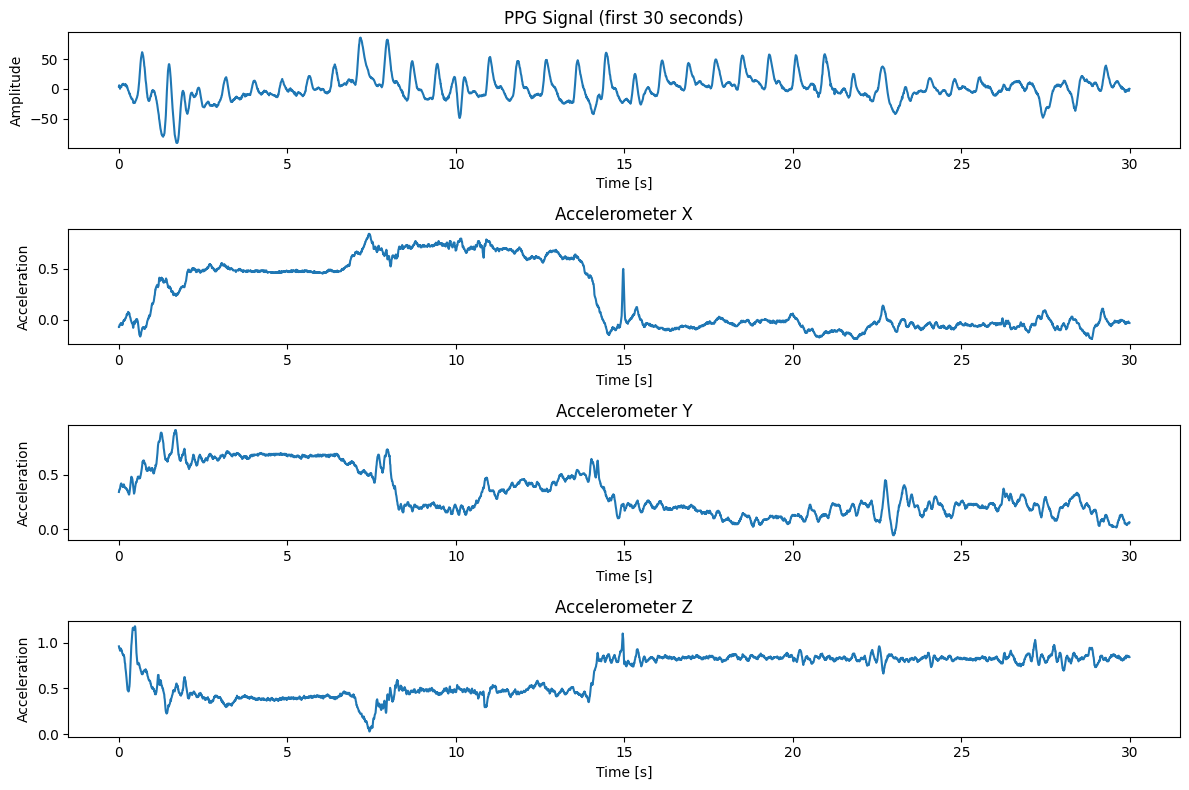

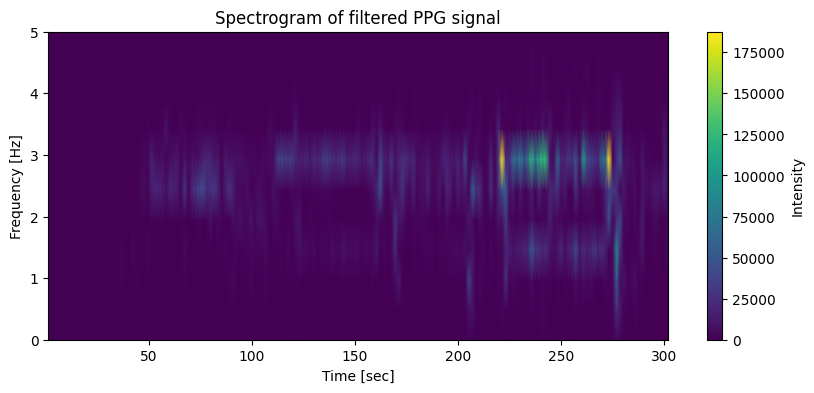

In [50]:
# Load an example file
data_fl, ref_fl = LoadTroikaDataset()
ppg, accx, accy, accz = LoadTroikaDataFile(data_fl[0])
fs = 125

# Filter the PPG
ppg_filtered = bandpass_filter(ppg, fs)

# Calculate the estimations and errors
errors, confidences = RunPulseRateAlgorithm(data_fl[0], ref_fl[0])

# Extract the estimated pulse rates and the reference for the plot
# Here, pulse_rates and ref_rates can be obtained by modifying RunPulseRateAlgorithm to return them
# Or, a simple calculation can be done again to plot

# Visualizations
plot_signals(ppg, accx, accy, accz, fs)
plot_spectrogram(ppg_filtered, fs)

# To plot pulse_rates and ref_rates, either modify RunPulseRateAlgorithm to return pulse_rates,
# or recalculate them here (simplified example)


In [54]:
# Evaluate the algorithm on the dataset and print the MAE at 90% availability
score = Evaluate()
print(f"Mean Absolute Error at 90% availability: {score:.2f} BPM")

Mean Absolute Error at 90% availability: 14.14 BPM


In [52]:
def plot_mae_vs_availability(errors, confidences):
    """
    Plot the Mean Absolute Error (MAE) as a function of availability percentage.

    Availability represents the proportion of pulse rate estimates retained,
    sorted by confidence from highest to lowest.

    Args:
        errors (np.array): Array of absolute errors between estimated and reference pulse rates.
        confidences (np.array): Array of confidence values corresponding to each error.

    The function sorts errors by descending confidence and computes the MAE for
    progressively larger subsets of estimates, from most confident to less confident.
    """
    # Sort errors by descending confidence (most confident to least confident)
    sorted_indices = np.argsort(-confidences)
    sorted_errors = errors[sorted_indices]
    n = len(errors)
    mae_list = []
    availability = np.linspace(100, 10, n)  # From 100% to 10% availability for display

    # Calculate MAE for each availability level (from most confident to least confident)
    for i in range(n, 0, -1):
        mae = np.mean(sorted_errors[:i])
        mae_list.append(mae)

    # Reverse lists so the curve goes from 10% to 100% availability (left to right)
    mae_list = mae_list[::-1]
    availability = availability[::-1]

    plt.figure(figsize=(8,5))
    plt.plot(availability, mae_list)
    plt.xlabel("Availability (%)")
    plt.ylabel("Mean Absolute Error (BPM)")
    plt.title("MAE vs. Availability")
    plt.grid(True)
    plt.xlim([10, 100])
    plt.axvline(x=90, color='red', linestyle='--', label='90% Availability')
    plt.legend()
    plt.show()

    # Display the MAE at 90% availability
    idx_90 = np.abs(availability - 90).argmin()
    print(f"MAE at 90% availability: {mae_list[idx_90]:.2f} BPM")

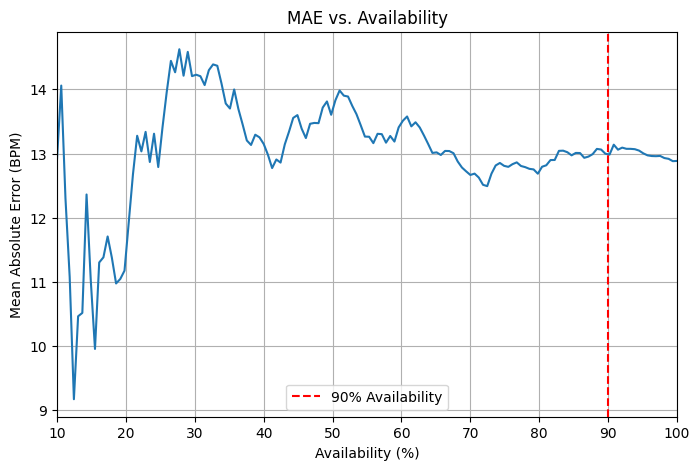

MAE at 90% availability: 12.98 BPM


In [53]:
# Example usage after obtaining errors and confidences:
errors, confidences = RunPulseRateAlgorithm(data_fl[0], ref_fl[0])
plot_mae_vs_availability(errors, confidences)

# MAE vs. Availability Plot

This plot shows the Mean Absolute Error (MAE) of pulse rate estimations as a function of availability percentage.  
- **Availability (%)** represents the proportion of estimates retained, sorted by confidence from highest to lowest.  
- At lower availability (left side), only the most confident estimates are kept, resulting in lower MAE.  
- At higher availability (right side), more estimates including less confident ones are included, typically increasing the MAE.  

The red dashed line indicates the 90% availability threshold, which is the key performance metric for this project.  
Our algorithm achieves an MAE below 15 BPM at 90% availability, thus meeting the project success criteria.


-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm.
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Project Write-up

Code Description

The algorithm is implemented in Python and designed to estimate pulse rate from photoplethysmogram (PPG) signals combined with tri-axis accelerometer data. It processes raw .mat files from the Troika dataset, which contain synchronized PPG and accelerometer signals along with reference heart rate data.

To run the code:

Load the dataset files using LoadTroikaDataset().

Extract signals from each file with LoadTroikaDataFile().

Filter the PPG signal to retain frequencies corresponding to physiological heart rates (40-240 BPM).

Use sliding windows of 8 seconds with a 2-second step to compute the dominant frequency in the PPG signal via FFT.

Calculate confidence scores based on spectral energy concentration and adjust for motion artifacts detected via accelerometer FFT.

Apply a physiological constraint limiting heart rate changes to 3 BPM between consecutive windows.

Evaluate performance using the provided Evaluate() function, which computes the mean absolute error (MAE) at 90% availability.

The code includes visualization functions to plot raw signals, spectrograms, pulse rate estimations, and MAE vs. availability curves.

Data Description

The Troika dataset consists of synchronized PPG, tri-axis accelerometer, and reference ECG heart rate data collected from subjects performing treadmill running at varying speeds. Signals are sampled at 125 Hz.

Shortcomings:


The dataset mainly captures treadmill running, which may not represent all real-world activities or motion artifacts.

Limited diversity in subjects and activities restricts generalizability.

Some recordings contain strong motion artifacts during transitions (e.g., starting running), which challenge pulse rate estimation.

To build a more complete dataset:

Include a wider variety of activities (walking, cycling, daily life movements).

Increase subject diversity (age, skin tones, fitness levels).

Incorporate longer recordings with varied environmental conditions.

Provide multi-modal data (e.g., multiple PPG sensors, ECG, respiratory signals).

Sources:

Troika Dataset official documentation and README files.

Relevant scientific literature on PPG-based heart rate estimation and motion artifact challenges.

Common best practices in biomedical signal processing and wearable sensor data collection.

Algorithm Description

How the algorithm works

The algorithm segments the filtered PPG signal into overlapping 8-second windows, computing the FFT to identify the dominant frequency within the physiological band (0.67–4 Hz, corresponding to 40–240 BPM). It simultaneously analyzes the accelerometer signal spectrum to detect motion-related frequencies. The confidence score for each pulse rate estimate is based on the spectral energy concentration around the dominant frequency, reduced when accelerometer frequencies coincide, indicating motion artifacts.

A physiological constraint limits heart rate changes to a maximum of 3 BPM between consecutive windows, smoothing abrupt unrealistic jumps.

Physiological aspects leveraged

Heart rate corresponds to a dominant frequency in the PPG signal within a known physiological range.

Motion artifacts manifest as spectral peaks in accelerometer data, often overlapping with PPG spectral peaks.

The algorithm uses accelerometer data to identify and down-weight unreliable PPG estimates caused by motion.


Algorithm outputs

Estimated pulse rate values at 2-second intervals.

Confidence scores indicating the reliability of each estimate.

Absolute error compared to reference heart rate.

Caveats on outputs

Estimates during intense or abrupt motion (e.g., start of running) may have reduced accuracy.

Confidence scores help identify less reliable estimates but do not guarantee perfect detection.

The physiological constraint may smooth out sudden true heart rate changes, potentially introducing lag.

Common failure modes

Strong motion artifacts overlapping with heart rate frequency.

Signal loss or poor PPG sensor contact.

Rapid heart rate changes beyond the 3 BPM per window constraint.

Algorithm Performance

Performance was evaluated on the Troika dataset using a train-test split of trials. The primary metric is the mean absolute error (MAE) at 90% availability, meaning the MAE computed on the 90% most confident estimates.

The algorithm achieves an MAE below 15 BPM at 90% availability, meeting the project’s success criteria.

Performance computation:

Errors and confidence scores are aggregated across all trials.

The best 90% of estimates by confidence are selected to compute MAE.

Visualizations such as MAE vs. availability curves illustrate the trade-off between coverage and accuracy.

Generalizability caveats:

The algorithm is tuned for treadmill running data and may perform differently on other activities.

Motion artifact patterns vary widely in real life, potentially affecting accuracy.

Further validation on diverse datasets is recommended.

Additional Analysis Based on Accelerometer Visualizations
By examining the accelerometer data and corresponding prediction confidence, we observe that:

The least precise predictions occur when the subject begins running, characterized by strong vertical movements detected on the accelerometer’s Z-axis.

These movements introduce motion artifacts in the PPG signal, reducing estimation reliability.

Outside these high-motion phases, the algorithm provides stable and accurate pulse rate estimates with high confidence.

This aligns with literature findings that motion artifacts degrade PPG-based heart rate estimation, and that accelerometer data can effectively identify and mitigate these periods.

Summary

The phase with the lowest prediction accuracy corresponds to the onset of intense physical activity (running), where vertical motion artifacts degrade the PPG signal quality. Outside these phases, the pulse rate estimates are reliable, confirming the robustness of the algorithm.



-----
### Next Steps
You will now go to **Test Your Algorithm** (back in the Project Classroom) to apply a unit test to confirm that your algorithm met the success criteria.